# HW1

By:
1. Roni Roitbord (313575599)
2. Lior Yaacov Ben Ezra (__YOUR ID__)



### 1. Quantization

In [28]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

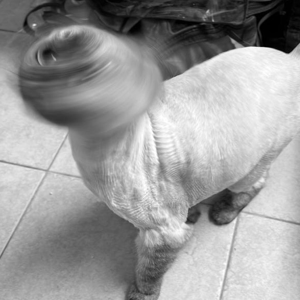

In [30]:
og_image = Image.open("./Drillocato.jpg")
gray_image = ImageOps.grayscale(og_image)
gray_image = gray_image.resize((300,300))
gray_image_arr = np.reshape(gray_image, gray_image.size[0] * gray_image.size[1])
display(gray_image)

### 1:
We would like to estimate the probability density function (pdf) of the gray levels
in the image using the image histogram. If the histogram seems too uniform, please
pick another image with a non-uniform distribution.

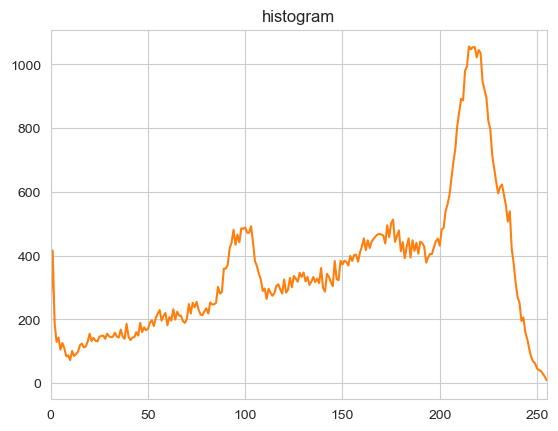

In [4]:
def calc_greyscale_hist(image):
    plt.plot(1,2)
    hist,bin = np.histogram(image,256,[0,255])
    plt.xlim([0,255])
    plt.plot(hist)
    plt.title("Image's PDF histogram")
    plt.show()

calc_greyscale_hist(gray_image)

We can see that the histogram does not represents a uniform distribution.

### 2:
 Apply uniform quantization on the image using b bits per pixel.
    a. Show the MSE as a function of the bit-budget b for b = 1, ..., 8.
    b. Plot the decision and representation levels for representative b values.

In [67]:
def uniform_quntizer(image_arr, bit):
    delta = (image_arr.max() - image_arr.min())/(2**bit)
    #Scaling
    unbiased_quantized_array = (np.floor((image_arr - image_arr.min())/delta)+0.5)*delta
    #biasing
    quantized_array = unbiased_quantized_array + image_arr.min()
    return quantized_array

#Calculte the MSE
def mse_on_grayscale():
    mse_array = []
    bits = range(1,9)
    for i in bits:
        mse_array.append(np.mean((gray_image_arr - uniform_quntizer(gray_image_arr, i+1))**2))
    plt.plot(bits, mse_array)
    plt.title("MSE as a function of the bit-budget b")
    plt.xlabel("b")
    plt.ylabel("MSE")

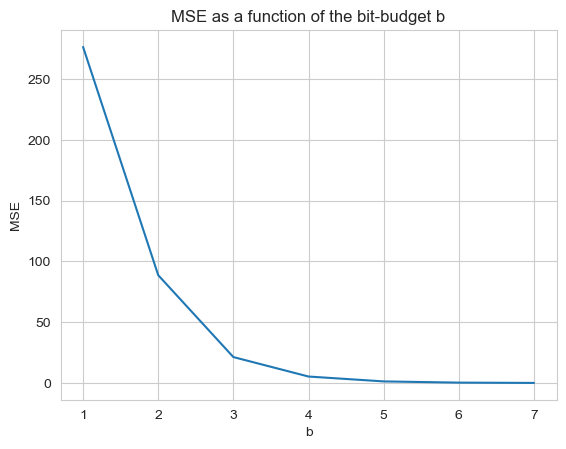

In [68]:
#quantized_image = uniform_quntizer(gray_image_arr, 5).reshape(gray_image.size[0],gray_image.size[1])
#plt.imshow(quantized_image, cmap='gray')
#plt.grid(None)
#plt.show()

mse_on_grayscale()

In [45]:
def get_levels(image_array, bit) :
    power_of_b = 2**bit
    decisions, representations = [],[]
    delta = (image_array.max() - image_array.min())/(power_of_b)
    for i in range(power_of_b+1) :
        decisions.append(image_array.min() + delta*i)
        if i != power_of_b-1:
            representations.append(image_array.min() + delta*(i+0.5))
    return decisions, representations

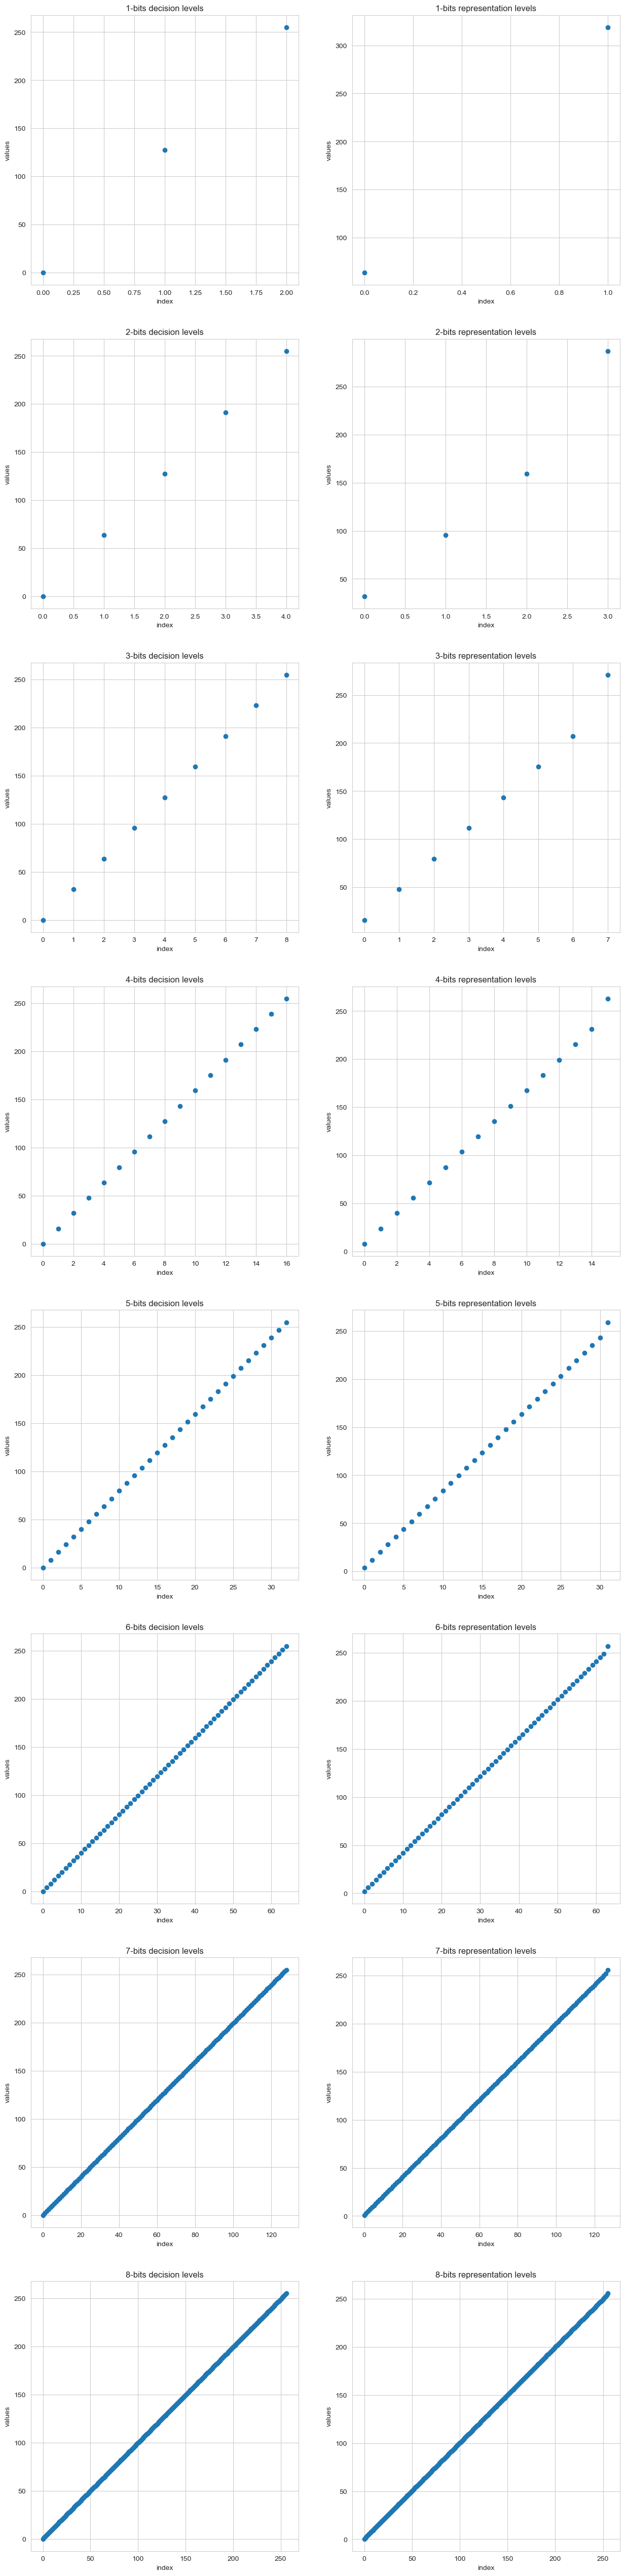

In [72]:
fig, axs = plt.subplots(8,2, figsize=(15, 65))
fig.subplots_adjust(hspace=0.2)
#fig.suptitle(title, fontsize=16, y=1.05)
axs = np.ravel(axs)

for i in range(8) :
    decisions, representations = get_levels(gray_image_arr, i+1)

    axs[2*i].plot(decisions, "o")
    axs[2*i].set_title(f"{i+1}-bits decision levels")
    axs[2*i].set_xlabel("index")
    axs[2*i].set_ylabel("values")

    axs[2*i+1].plot(representations, "o")
    axs[2*i+1].set_title(f"{i+1}-bits representation levels")
    axs[2*i+1].set_xlabel("index")
    axs[2*i+1].set_ylabel("values")
plt.show()

### 3:

Implement the Max-Lloyd algorithm. This should be a function taking as input
a histogram pdf, a vector of initial decision levels, and a small value ε > 0 for
convergence tolerance. The function should return the converged decision levels and
the converged representation levels. In order to handle numerical approximations,
we use ε as a stopping condition: when the MSE improves by less than ε we stop the
algorithm.

In [128]:
def calculate_decision(representations, decisions):
    updated_decisions = np.zeros(len(decisions))
    for i in range(len(decisions) - 2):
        updated_decisions[i+1] = (representations[i] + representations[i+1]) / 2
    return updated_decisions

def calculate_representation(hist, decisions):
    num_decisions = len(decisions)
    x_px = np.array([x * hist[x] for x in range(hist.size)])
    representations = np.zeros(num_decisions - 1, dtype=float)
    for i in range(num_decisions-1):
        low_bound = np.ceil(decisions[i])
        high_bound = np.ceil(decisions[i + 1])
        hist_sum = np.sum(hist[int(low_bound):int(high_bound)])
        x_px_sum = np.sum(x_px[int(low_bound):int(high_bound)])
        if hist_sum == 0 or x_px_sum == 0:
            representations[i] = (decisions[i] + decisions[i + 1]) / 2
        else:
            representations[i] = x_px_sum / hist_sum
    return representations

def calculate_mse(hist, representation_levels, num_samples):
    squared_diff = np.square(representation_levels[:, np.newaxis] - np.arange(hist.size))
    weighted_squared_diff = hist * np.min(squared_diff, axis=0)
    mse = np.sum(weighted_squared_diff) / num_samples
    return mse


def maxloyd(hist, decision_levels, epsilon):
    num_samples = np.sum(hist)
    representations = calculate_representation(hist, decision_levels)
    old_mse = calculate_mse(hist, representations, num_samples)
    new_decisions = np.copy(decision_levels)
    while True:
        new_decisions = calculate_decision(representations, new_decisions)
        representations = calculate_representation(hist, new_decisions)
        mse = calculate_mse(hist, representations, num_samples)
        print(mse)
        if np.abs(mse - old_mse) < epsilon:
            return mse

In [129]:
mse_array = np.zeros(8, dtype=np.float64)
hist = np.histogram(gray_image_arr, bins=range(257))
for i in range(8) :
    decision, representation = get_levels(gray_image_arr,i+1)
    mse = maxloyd(hist[0], decision, 0.1)
    mse_array[i] = mse
plt.plot(range(1,9), mse_array)
plt.title("MSE as a function of the bit-budget b")
plt.xlabel("b")
plt.ylabel("MSE")
plt.show()

9478.423569863351
17150.979613807194
22446.55210649964
25227.605362233968
26761.49198572841
27527.25023959421
27850.778600442256
27976.79362751059
28030.8847467189
28057.953306600353
28071.4933366104
28078.264789132758
28081.65087477327
28083.34400743836
28084.190596232107
28084.61389624429
28084.82554765421
28084.931373710115
28084.98428682581
28085.010743405597
28085.023971700964
28085.03058585002
28085.0338929249
28085.03554646242
28085.036373231203
28085.036786615594
28085.036993307796
28085.0370966539
28085.03714832695
28085.03717416348
28085.037187081733
28085.03719354087
28085.03719677044
28085.037198385216
28085.037199192615
28085.037199596303
28085.037199798157
28085.03719989907
28085.037199949544
28085.037199974766
28085.037199987386
28085.03719999369
28085.03719999685
28085.037199998427
28085.037199999206
28085.03719999961
28085.03719999981
28085.037199999904
28085.037199999948
28085.037199999973
28085.037199999995
28085.037199999995
28085.0372
28085.0372
28085.0372
28085.03

KeyboardInterrupt: 